## 1. Train Classification Models

In [3]:
import h5py
import numpy as np
import os
#print(os.listdir("./Input/train"))
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

## 1.1 Read Training Dataset & Understand Dataset

In [4]:
###### Read training data
with h5py.File('./Input/images_training.h5','r') as H:
    train_x = np.copy(H['datatrain'])

with h5py.File('./Input/labels_training.h5','r') as H:
    train_y = np.copy(H['labeltrain'])

print(train_x.shape,train_y.shape)

(30000, 784) (30000,)


In [5]:
###### Check distinct class
print("Include these classes:",np.unique(train_y))

Include these classes: [0 1 2 3 4 5 6 7 8 9]


Number of each class: [3041, 2972, 2936, 3008, 2954, 3029, 3023, 3013, 3040, 2984]
Average class size: 3000.0


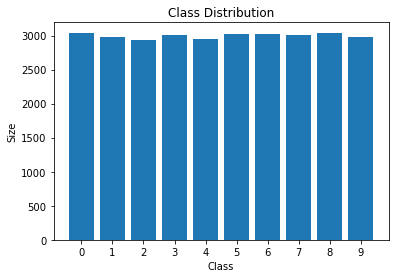

In [6]:
###### Visualise dataset
number_of_class = len(np.unique(train_y)) # 10 classes


each_class_size = []
for nc in range(number_of_class):
    xy_nc = train_x[train_y == nc] # identify instance that with specific label 
    each_class_size.append(xy_nc.shape[0])
    
print("Number of each class:",each_class_size)
print("Average class size:",np.mean(each_class_size))
plt.bar(range(number_of_class), each_class_size)
plt.xticks(range(number_of_class))
plt.ylabel("Size")
plt.xlabel("Class")
plt.title('Class Distribution')
plt.show()


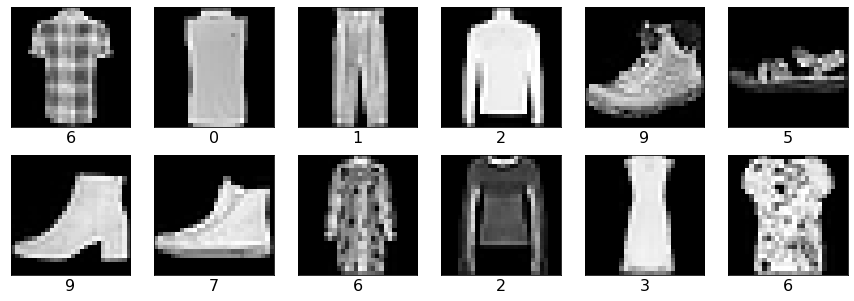

In [7]:
####### Reshape data & Plot first 12 images
image_data = train_x.reshape((train_x.shape[0], 28, 28)) 
#(30000,784) --> (30000,28,28)

plt.figure(figsize=(15,5))
for img in range(12):
    plt.subplot(2,6,img+1)
    plt.imshow(image_data[img],cmap=plt.get_cmap('gray'))
    plt.xticks([]),plt.yticks([])
    plt.xlabel(train_y[img],fontsize=16)   
plt.show()

## 1.2 Split Dataset -> Training / Validation

In [8]:
np.random.seed(500709979)
index = np.arange(len(train_x))
percentage_of_train = int(0.85 * len(train_x)) # set the 80% of 30000 to training data
np.random.shuffle(index)   # shuffle the instances of the training dataset randomly
train_index = index[ :percentage_of_train]
test_index = index[percentage_of_train: ]

In [9]:
data_train, data_test = train_x[train_index], train_x[test_index]
labels_train, labels_test = train_y[train_index], train_y[test_index]

data_train.shape, data_test.shape, labels_train.shape, labels_test.shape

((25500, 784), (4500, 784), (25500,), (4500,))

In [10]:
####### check if training data and validation data all have 10 classes
print(np.unique(labels_train))
print(np.unique(labels_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [11]:
####### reshape label data
y_train = np.array(labels_train).reshape(-1, 1)   # (22500, ) --> (22500,1)
y_test = np.array(labels_test).reshape(-1, 1)     # (7500, ) --> (7500,1)

print(y_train.shape)
print(y_test.shape)

(25500, 1)
(4500, 1)


## 1.3 Mean subtraction

In [12]:
def mean_centering(required_data):
    mean_vector = np.mean(required_data, axis = 0) # get mean of each feature
    required_data = required_data - mean_vector # subtract mean
    return(required_data)

In [13]:
mc_train = mean_centering(data_train)
mc_test = mean_centering(data_test)

mc_train.shape, mc_test.shape

((25500, 784), (4500, 784))

## 1.4 PCA

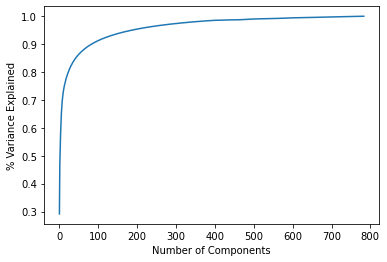

Choose 186 principal components can explain more than 95% of data


In [21]:
###### PCA on training dataset (mc_train)  --> to determine how many principal components should be selected

###### Get covariance matrix of training dataset
cov = np.cov(mc_train.T)
#print(cov.shape)

###### Get eigenvalue and eigenvector from training dataset
eigvalues, eigvectors = np.linalg.eig(cov)
#print(eigvectors.shape)

###### See how much variance can be explained by increasing number of components
explained_var = [] 
for i in eigvalues:
     explained_var.append(i / np.sum(eigvalues))       
sum_explained_var = np.cumsum(explained_var) #  get the cumulative sum of the explained variance

###### Visualise the relationship between components and explained data
plt.plot(sum_explained_var)
plt.xlabel("Number of Components")
plt.ylabel("% Variance Explained")
plt.show()

###### choose number of components that can explain more than 95% data
components=0
for i in sum_explained_var:
    if i <= 0.95:
        components +=1
print("Choose " + str(components) + " principal components can explain more than 95% of data")

proj_matrix = (eigvectors.T[:][:components]).T # Get project matrix of training data

In [22]:
###### Apply PCA on train data
train_pca = mc_train.dot(proj_matrix)
train_pca.shape

(25500, 186)

In [23]:
###### Apply PCA on test data
test_pca = mc_test.dot(proj_matrix)

test_pca.shape

(4500, 186)

## 1.5 KNN

### 1.5.1 KNN Classifier

In [24]:
##### KNN model
def knn_model(traindata, y_train, K, components, testdata):
    # calculate Euclidean distance between test data point and whole training data
    # then sort the distance (from shortest to fartest) 
    # then get the index of nearest ones
    nearest_one = np.argsort(np.sum((traindata - testdata.reshape((components,1)).T)**2, axis = 1))
    
    labels = np.zeros(10) # set the initial array --> to count neighbor belongs to which Class
    for kk in range(K):
        if y_train[nearest_one[kk]]==0:   # the nearest one is Class0
            labels[0] += 1
        elif y_train[nearest_one[kk]]==1: # the nearest one is Class1
            labels[1] += 1
        elif y_train[nearest_one[kk]]==2: # the nearest one is Class2
            labels[2] += 1
        elif y_train[nearest_one[kk]]==3: # the nearest one is Class3
            labels[3] += 1
        elif y_train[nearest_one[kk]]==4: # the nearest one is Class4
            labels[4] += 1
        elif y_train[nearest_one[kk]]==5: # the nearest one is Class5
            labels[5] += 1
        elif y_train[nearest_one[kk]]==6: # the nearest one is Class6
            labels[6] += 1
        elif y_train[nearest_one[kk]]==7: # the nearest one is Class7
            labels[7] += 1
        elif y_train[nearest_one[kk]]==8: # the nearest one is Class8
            labels[8] += 1
        elif y_train[nearest_one[kk]]==9: # the nearest one is Class9
            labels[9] += 1            
        else:
            print('Error')           
    return np.argmax(labels)  # get the highest one

### 1.5.2 Hyperparameter Tuning & Validation

In [25]:
##### Accuracy
def acc(out_class,label):
    compare = np.hstack((out_class,label))
    tptn=0
    for i in compare:
        if i[0] == i[1]:
            tptn = tptn + 1   #print(tptn)
    acc = tptn / len(compare) * 100
    return acc

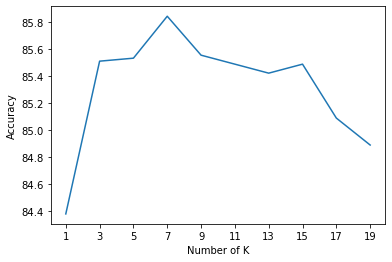

{1: 84.37777777777778, 3: 85.51111111111112, 5: 85.53333333333333, 7: 85.84444444444445, 9: 85.55555555555556, 11: 85.4888888888889, 13: 85.42222222222222, 15: 85.4888888888889, 17: 85.08888888888889, 19: 84.88888888888889}
Heighest Accuracy: 85.84444444444445
Best K: 7
1027.938 s


In [26]:
'''
st = time.time()
##### Hyperparameter tuning for KNN
##### To choose the best K   --> around 17 mins for 10 rounds 

accuracy = []
nk = []
components = 186
for k in range(1,20, 2):   # k = 1,3,5,...,17,19
    nk.append(k)
    
    out_classified = np.empty((len(y_test),1))
    for i in range(len(y_test)):
        out_classified[i,0] = knn_model(train_pca, y_train, k, components, test_pca[i,:]) 
    
    accuracy.append(acc(out_classified, label = y_test ))

plt.plot(nk, accuracy)
plt.xlabel("Number of K")
plt.xticks(nk)
plt.ylabel("Accuracy")

plt.show()

k_acc = dict(zip(nk, accuracy))
best_K = max(k_acc, key = k_acc.get)
print(k_acc)
print("Heighest Accuracy:", max(accuracy))
print("Best K:", best_K)

print(round((time.time()- st),3),"s")
'''

In [27]:
st = time.time()
##### Apply KNN model to predict class label for test data
##### run 1'38s for 4500 test data

K = 7
components=186
out_class_knn = np.empty((len(y_test),1))
for i in range(len(y_test)):
    out_class_knn[i,0] = knn_model(train_pca, y_train, K, components,test_pca[i,:])  
    
print(round((time.time()- st),3),"s")    

108.553 s


In [28]:
##### Get accuracy
accuracy_KNN = sum(out_class_knn == y_test) / len(y_test) * 100
print("Accuracy is: {}%".format('%.3f'%accuracy_KNN))

Accuracy is: 85.844%


In [29]:
out_class_knn.shape

(4500, 1)

## 1.6 Naive Bayes Classifier & Validation

In [30]:
train_pca.shape, test_pca.shape, labels_train.shape, labels_test.shape

((25500, 186), (4500, 186), (25500,), (4500,))

In [31]:
##### for training data (train_pca) <- 25500

train_records, train_features = train_pca.shape  # 30000 records , 784 features 
num_classes = len(np.unique(labels_train)) # 10 Classes

print(train_records, train_features, num_classes)

cl_mean = {}     # mean of each feature for each Class -> 10 * 784
cl_variance = {} # variance of each class
cl_prior = {}    # class prior --> P(Class)

for i in range(num_classes):
    Xy_i = train_pca[labels_train == i] # seperate records into different Classes
    
    cl_mean[i] = Xy_i.mean(axis=0)
    cl_variance[i] = Xy_i.var(axis=0)  # get variance of each class
    cl_prior[i] = Xy_i.shape[0] / train_records  # probability of being a certain Class

25500 186 10


In [32]:
##### Gaussian density function 
# assume all probability of each feature is normally distributed

def Gaussian_density(xx, mean, var): # use mean & variance of training data
    p1 = - xx.shape[1] / 2 * math.log(2 * math.pi) - 1/2 * sum(np.log(var + (1e-2)))
    p2 = 1/2 * np.sum(np.power(xx - mean, 2) / (var + (1e-2)), 1) 
    result = p1 - p2
    return result  # gaussian probability


##### Predict Class
# for validation data (test_pca) <- 4500

def prediction(test):
    # posterior
    post = np.zeros((test.shape[0], num_classes))  # 2000 * 10      
    for i in range(num_classes):  # for Class 0~9
        post_i = Gaussian_density(test, cl_mean[i], cl_variance[i]) 
        prior = cl_prior[i] # prior
        post[:,i] = post_i * prior  # likelihood * prior

    return np.argmax(post, 1)

In [33]:
st = time.time()

##### apply Naive Bayes on validation dataset
out_class_nb = prediction(test_pca) # RESULT 
print(out_class_nb.shape)

##### get accuracy
accuracy_NB = sum(out_class_nb == labels_test)/len(labels_test)*100
print("Naive Bayes model Accuracy is: {}%".format('%.3f'%accuracy_NB))  # ACCURACY -> 74.111%

print(round((time.time()- st),3),"s")


(4500,)
Naive Bayes model Accuracy is: 74.111%
0.398 s


# 2. TEST 

## 2.1 Read Test Dataset

In [44]:
###### read test data ######

with h5py.File('./Input/images_testing.h5','r') as H:  # read test data
    data_test = np.copy(H['datatest'])
print(data_test.shape)
'''
with h5py.File('./Input/labels_testing_2000.h5','r') as H:  # read label of test data
    label_test = np.copy(H['labeltest'])
print(label_test.shape)

print("Classes:",np.unique(label_test))
'''

(5000, 784)
(2000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


## 2.2 Data Preprocessing

In [45]:
###### mean-centering
def mean_centering(required_data):
    mean_vector = np.mean(required_data, axis = 0) # get mean of each feature
    required_data = required_data - mean_vector # subtract mean
    return(required_data)

mc_tr = mean_centering(train_x)
mc_tt = mean_centering(data_test)

mc_tr.shape, mc_tt.shape

((30000, 784), (5000, 784))

In [46]:
###### PCA for full training data(30000) and test data(5000)
cov = np.cov(mc_tr.T) # covariance matrix of training data

eigvalues, eigvectors = np.linalg.eig(cov) # Get eigenvalue and eigenvector from training dataset

explained_var = []
for i in eigvalues:
     explained_var.append(i / sum(eigvalues))       
sum_explained_var = np.cumsum(explained_var) # see how many components can explain how much data

components=0
for i in sum_explained_var:
    if i<=0.95:  # choose number of components that can explain more than 95% data
        components +=1
print("Choose " + str(components) + " principal components can explain more than 95% of data")

proj_matrix = (eigvectors.T[:][:components]).T # project matrix

tr_pca = mc_tr.dot(proj_matrix)  # apply PCA on training dataset
tt_pca = mc_tt.dot(proj_matrix)  # apply PCA 

tr_pca.shape, tt_pca.shape

Choose 187 principal components can explain more than 95% of data


((30000, 187), (5000, 187))

## 2.3 Apply KNN on full test data

In [48]:
###### reshape
y_tr = np.array(train_y).reshape(-1, 1)     #(30000, ) --> (30000,1)
#y_tt = np.array(label_test).reshape(-1, 1)  #(2000, ) --> (2000,1)

y_tr.shape #, y_tt.shape

(30000, 1)

In [38]:
st = time.time()

K = 7
components = 187

output_KNN_5000 = np.empty((len(tt_pca),1))  # 5000 output
for i in range(len(tt_pca)):
    output_KNN_5000[i,0] = knn_model(tr_pca, y_tr, K, components, tt_pca[i,:]) 

print(round((time.time()- st),3),"s") # cost around 155s

145.66 s


In [39]:
'''
#accuracy of first 2000 test data
acc_KNN_2000 = sum(output_KNN_5000[:2000] == y_tt)/len(y_tt)*100
print("KNN classifier accuracy(first 2000 test examples) is: {}%".format('%.3f'%acc_KNN_2000))
'''

KNN classifier accuracy(first 2000 test examples) is: 83.700%


## 2.4 Save output to file

In [40]:
###### save the output file
# output --> predicted labels (5000,) 

output = np.reshape(output_KNN_5000, -1) #(5000,1) -> (5000,)

with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)